In [80]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [81]:
import math
import copy
import random
from dataclasses import dataclass

In [82]:
from algo.dynamicProgramming import dynamicPlayer
from algo.iplayer import RandomPlayer, IPlayer
from algo.q_learning import QLearning
from algo.board import Board, GameState

In [83]:
device = torch.device(
    # "cuda" if torch.cuda.is_available() else
    # "mps" if torch.backends.mps.is_available() else
    "cpu"
)
device

device(type='cpu')

In [84]:
class DQN(nn.Module):
	"""
	Using structure similar to NNUE:
	https://www.chessprogramming.org/File:StockfishNNUELayers.png
	
	Observation space: hot-encoded board:
	for each of 18 cells we can be -2, -1, 0, 1, 2 (5 possibilities).
	In total it gives 18 * 5 = 90 possible inputs, out of which at most 12 are on.
	
	# Action space: 4 possible actions.
	Value function: 1 output. # https://www.reddit.com/r/reinforcementlearning/comments/1b1te73/help_me_understand_why_use_a_policy_net_instead/
	"""

	def __init__(self):
		super(DQN, self).__init__()

		layer_sizes = [
			90,
			52,
			10,
			1
		]

		layers = []
		prev_size = layer_sizes[0]
		for cur_size in layer_sizes[1:]:
			layer = nn.Linear(prev_size, cur_size)
			nn.init.kaiming_uniform(layer.weight, nonlinearity='relu')
			layers.append(layer)
			prev_size = cur_size

		self.layers = nn.ModuleList(layers)

	def forward(self, board: Board) -> torch.Tensor:
		state = board.to_tensor(device)
		for layer in self.layers[:-1]:
			state = F.relu(layer(state))
		return self.layers[-1](state)

In [85]:
def make_environment_step(state: Board, action: tuple[tuple[int, int], tuple[int, int]], enemy: IPlayer, current_step: int) -> tuple[Board, torch.Tensor]:
	"""
	Returns new state and reward for the given action.
	"""
	state = copy.deepcopy(state)
	cur_sign = state.turn_sign
	we_captured = state.make_move(*action) * cur_sign
	enemy_captured = 0
	while state.game_state == GameState.NOT_OVER and state.turn_sign != cur_sign:
		enemy_captured += state.make_move(*enemy.decide_move(state)) * cur_sign * (-1)

	reward = 3*(we_captured - enemy_captured)
	# if current_step > 10 and not we_captured:
	# 	reward -= 2
		
	if state.game_state != GameState.NOT_OVER:
		our_pieces = 0
		enemy_pieces = 0
		for _, piece in state:
			if piece == cur_sign:
				our_pieces += 1
			elif piece == -cur_sign:
				enemy_pieces += 1
			elif piece == 2 * cur_sign:
				our_pieces += 2
			elif piece == -2 * cur_sign:
				enemy_pieces += 2
			
		reward += 3 * our_pieces / (enemy_pieces + 1)

		if state.game_state == GameState.DRAW:
			reward -= 40
		elif state.game_state == GameState(cur_sign):
			reward += 40
		elif state.game_state == GameState(-cur_sign):
			reward -= 40
		else:
			raise ValueError("Unexpected game state")
	
	return state, torch.Tensor([reward])

In [86]:
GAMMA = 0.99 # discount rate

@dataclass
class Action:
	action: tuple[tuple[int, int], tuple[int, int]]
	value: torch.Tensor

def q_s(dqn: DQN, current_state: Board) -> list[Action]:
	"""
	Return: list[(new_state, action, immediate_reward, value)]
	"""
	ret: list[Action] = []
	for s in current_state.get_possible_pos():
		for e in current_state.get_correct_moves(s):
			next_state = copy.deepcopy(current_state)
			immediate_reward = torch.tensor([next_state.make_move(s, e) * next_state.turn_sign], device=device)
			value = dqn(next_state) * GAMMA + immediate_reward
			ret.append(Action((s, e), value))
	return ret

In [87]:
BATCH_SIZE = 128 # number of transitions sampled from the replay buffer

EPS_START = 0.9 # exploration rate
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005 # update rate
LR = 1e-4 # AdamW learning rate

policy_net = DQN().to(device) # to be updated often
target_net = DQN().to(device) # to be updated with TAU
# policy_net.load_state_dict(torch.load("dqn80.pth"))
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
steps_done = 0


def select_action(board: Board) -> Action:
	global steps_done
	sample = random.random()
	eps_threshold = EPS_END + (EPS_START - EPS_END) * \
		math.exp(-1. * steps_done / EPS_DECAY)
	steps_done += 1
	if sample > eps_threshold:
		with torch.no_grad():
			state_values = q_s(policy_net, board)
			return max(state_values, key=lambda x: x.value.item())
					
	else:
		possible_moves = []
		for s in board.get_possible_pos():
			for e in board.get_correct_moves(s):
				possible_moves.append((s, e))
		return Action(
			random.choice(possible_moves),
			torch.tensor([0], device=device)
		)

C:\Users\mario\AppData\Local\Temp\ipykernel_312304\2008860337.py:28: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  nn.init.kaiming_uniform(layer.weight, nonlinearity='relu')


In [88]:
@dataclass
class TransitionRecord:
	current_state: Board
	next_state: Board
	immediate_reward: torch.Tensor

def optimize_model(memory: list[TransitionRecord]):
	if len(memory) < BATCH_SIZE:
		return
	
	state_action_values = []
	expected_state_action_values = []

	for r in random.sample(memory, BATCH_SIZE):
		# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
		# columns of actions taken. These are the actions which would've been taken
		# for each batch state according to policy_net
		state_action_values.append(
			max(q_s(policy_net, r.current_state), key=lambda x: x.value.item()).value
		)

		next_state_value = 0
		if r.next_state.game_state == GameState.NOT_OVER:
			next_state_action = max(q_s(policy_net, r.next_state), key=lambda x: x.value.item()).action

			with torch.no_grad():
				next_state_value = next(a.value for a in q_s(target_net, r.next_state) if a.action == next_state_action)
		# Compute the expected Q values
		expected_state_action_values.append((next_state_value * GAMMA) + r.immediate_reward)

	# Compute Huber loss
	criterion = nn.SmoothL1Loss()
	loss = criterion(
		torch.cat(state_action_values),
		torch.cat(expected_state_action_values)
	)

	# Optimize the model
	optimizer.zero_grad()
	loss.backward()
	# In-place gradient clipping
	torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
	optimizer.step()

In [89]:
def run_game(net: DQN) -> int:
	enemy = RandomPlayer(random.randint(0, 10000))
	board = Board()
	while board.game_state == GameState.NOT_OVER:
		while board.game_state == GameState.NOT_OVER and board.turn_sign == 1:
			board.make_move(*enemy.decide_move(board))
		while board.game_state == GameState.NOT_OVER and board.turn_sign == -1:
			with torch.no_grad():
				state_values = max(q_s(net, board), key=lambda x: x.value.item())
				board.make_move(*state_values.action)
	
	pieces = 0
	for _, piece in board:
		pieces += piece != 0

	return (1 if board.game_state == GameState(-1) else -1) * pieces

In [90]:
max_score = 0
backup = None

In [91]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
	num_episodes = 600
else:
	num_episodes = 50
	
memory: list[TransitionRecord] = []

win_rate = []
number_of_steps = []

enemy = RandomPlayer(random.randint(0, 1000))
q_enemy = QLearning("dqn80.pth")
random_enemy = RandomPlayer(random.randint(0, 1000))

for i_episode in range(num_episodes):
	enemy = random.choice([q_enemy, random_enemy])
	# enemy = random_enemy
	cur_state = Board()
	
	if i_episode % 2 == 0:
		our_sign = -1
		cur_state.make_move(*enemy.decide_move(cur_state))
	else:
		our_sign = 1

	num_steps = 0
	while True:
		num_steps += 1
		action = select_action(cur_state)
		new_state, immediate_reward = make_environment_step(cur_state, action.action, enemy, num_steps)

		memory.append(TransitionRecord(cur_state, new_state, torch.tensor([immediate_reward], device=device)))
		cur_state = new_state
		
		# Soft update of the target network's weights
		# θ′ ← τ θ + (1 −τ )θ′
		target_net_state_dict = target_net.state_dict()
		policy_net_state_dict = policy_net.state_dict()
		for key in policy_net_state_dict:
			target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
		target_net.load_state_dict(target_net_state_dict)

		if cur_state.game_state != GameState.NOT_OVER:
			win_rate.append(cur_state.game_state == GameState(our_sign))
			break

	# Perform one step of the optimization (on the policy network)
	optimize_model(memory)

	number_of_steps.append(num_steps)
	stats = [run_game(target_net) for _ in range(20)]
	a = sum(win_rate[-20:])
	b = sum(x > 0 for x in stats)

	if a * b > max_score:
		max_score = a * b
		backup = copy.deepcopy(target_net)

	print(f"Episode {i_episode} finished. {a}/{20} | {b}/20  {sum(number_of_steps)/len(number_of_steps)}")

print('Complete')

Episode 0 finished. 0/20 | 11/20  8.0
Episode 1 finished. 0/20 | 12/20  9.0
Episode 2 finished. 0/20 | 10/20  11.666666666666666
Episode 3 finished. 0/20 | 12/20  13.0
Episode 4 finished. 0/20 | 11/20  14.8
Episode 5 finished. 0/20 | 13/20  14.166666666666666
Episode 6 finished. 1/20 | 15/20  13.714285714285714
Episode 7 finished. 1/20 | 13/20  15.5
Episode 8 finished. 1/20 | 15/20  15.11111111111111
Episode 9 finished. 1/20 | 13/20  14.6
Episode 10 finished. 2/20 | 14/20  14.090909090909092
Episode 11 finished. 3/20 | 11/20  14.5
Episode 12 finished. 3/20 | 17/20  14.692307692307692
Episode 13 finished. 3/20 | 12/20  16.285714285714285
Episode 14 finished. 4/20 | 12/20  15.8
Episode 15 finished. 4/20 | 15/20  15.375
Episode 16 finished. 4/20 | 14/20  15.352941176470589
Episode 17 finished. 5/20 | 16/20  15.222222222222221
Episode 18 finished. 5/20 | 9/20  16.210526315789473
Episode 19 finished. 5/20 | 12/20  16.15
Episode 20 finished. 5/20 | 11/20  15.80952380952381
Episode 21 finishe

KeyboardInterrupt: 

In [92]:
sum(win_rate) / len(win_rate)

0.384928716904277

In [93]:
len(win_rate)

491

In [94]:
sum(win_rate)

189

In [95]:
max_score

np.int64(225)

In [96]:
from matplotlib import pyplot as plt

(np.int64(618), 1000)

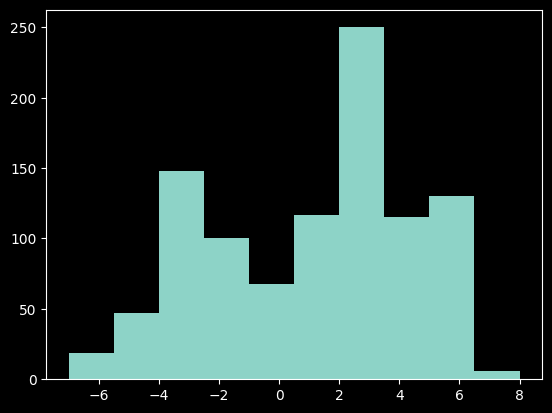

In [97]:
stats = [run_game(target_net) for _ in range(1000)]

plt.hist(stats)
sum(x > 0 for x in stats), len(stats)

(np.int64(585), 1000)

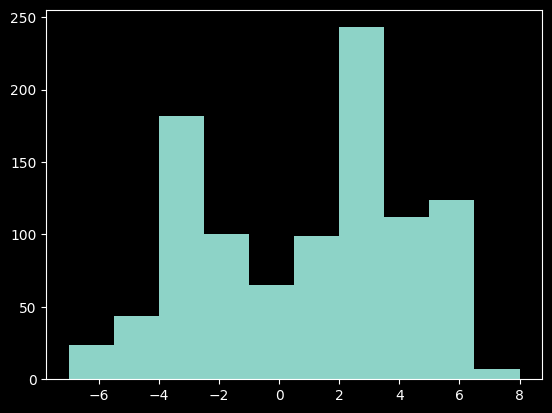

In [98]:
stats = [run_game(policy_net) for _ in range(1000)]

plt.hist(stats)
sum(x > 0 for x in stats), len(stats)

(np.int64(587), 1000)

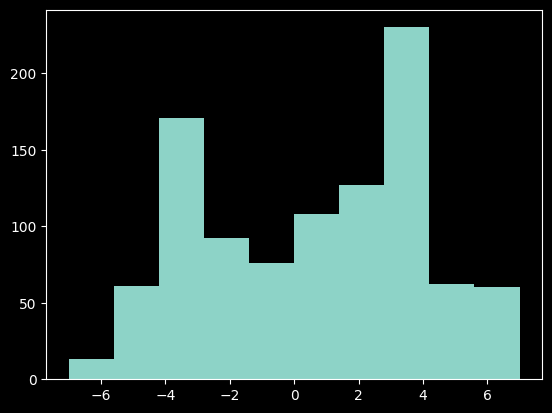

In [99]:
assert backup
stats = [run_game(backup) for _ in range(1000)]

plt.hist(stats)
sum(x > 0 for x in stats), len(stats)

In [100]:
# torch.save(policy_net.state_dict(), "~dqn83 90 50 20 1.pth")

In [101]:
# target_net.load_state_dict(torch.load("dqn.pth"))